# Example 3.2

<p style="width:10%; float:right; padding-left: 50px;">
    <img src="../images/book_cover.jpg">
</p>

From Parameter Estimation and Inverse Problems, 3rd edition, 2018 by R. Aster, B. Borchers, C. Thurber

### Implemented in Python by:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

In [1]:
%reset -f

## Imports

In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as nla

from peiplib.plot import get_cbar_axes

In [2]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

## Instrument response to unit area ground acceleration impulse

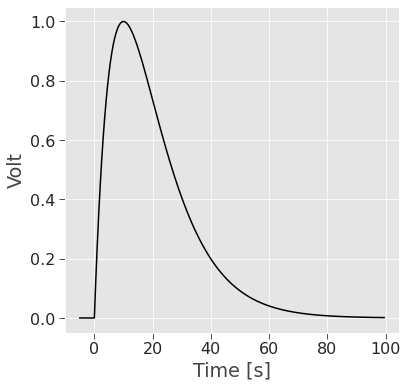

In [3]:
# Time interval
tmin, tmax = -5, 100

# Instrument characteristic time constant in [s]
T0 = 10

# Discretizing values for M & N (210 data points)
M = N = 211

# Generate time vector
t = np.linspace(tmin, tmax, N)

# Generate instrument impulse response
g = np.zeros(N-1, dtype=np.float64)

for i in range(N-1):
    if t[i] > 0:
        g[i] = t[i] * np.exp(-t[i] / T0)

# Normalize instrument response (i.e. max(g)=1)
g0 = np.exp(1) / T0
g *= g0

# Plot of instrument response
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[:N-1], g, 'k')
ax.set(xlabel='Time [s]', ylabel='Volt');

## Dicretising the problem - System matrix, $\textbf{G}$

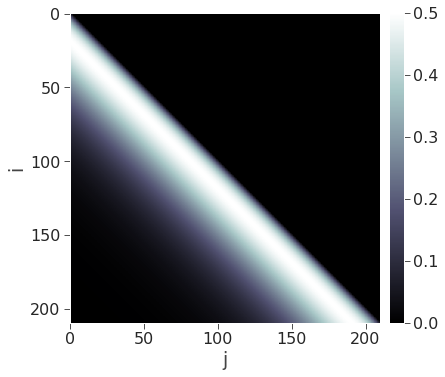

In [4]:
# Populate G matrix
G = np.zeros((M-1, N-1), dtype=np.float64)

for i in range(1, M):
    for j in range(N-1):
        tp = t[i] - t[j]
        if tp > 0:
            G[i-1, j] = tp * np.exp(-tp / T0)

# Now divide everything by the denominator
deltat = t[1] - t[0]
G *= (g0 * deltat)

# Display image of matrix G
fig = plt.figure()
ax = fig.add_subplot(111)
cimg = ax.imshow(G, cmap='bone')
cax = get_cbar_axes(ax)
cbar = plt.colorbar(cimg, cax=cax)
ax.set(
    xlabel='j', ylabel='i', xticks=np.arange(0.0, 250, 50),
    yticks=np.arange(0.0, 250, 50))

ax.grid(False)

## Singular-Value Decomposition (SVD) of matrix $\textbf{G}$

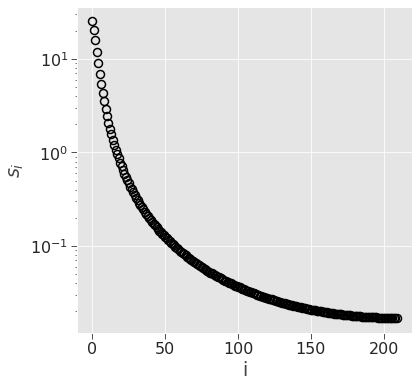

In [5]:
U, S, VT = nla.svd(G, compute_uv=True, full_matrices=True)
V = np.transpose(VT)

# Display semilog plot of singular values
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.semilogy(S, 'ko', mfc='None')
ax2.set(xlabel='i', ylabel=r'$s_{i}$', xticks=range(0, S.size+1, 50));

## True model

We consider a true ground acceleration signal that consists of two acceleration pulses with widths of `σ=2`s, centered at `t=8`s and `t=25`s.

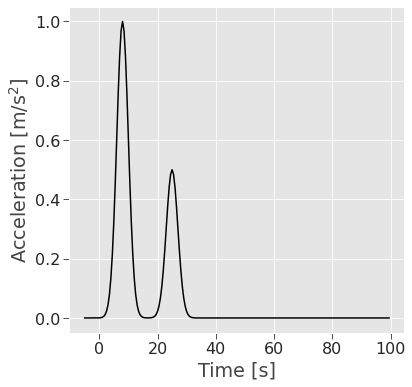

In [6]:
# True signal is two pulses of sigma deviation
sigma = 2
tt = t[:N-1]
pulse1 = np.exp(-(tt - 8)**2 / (2 * sigma**2))
pulse2 = 0.5 * np.exp(-(tt - 25)**2 / (2 * sigma**2))
mtrue = pulse1 + pulse2
mtrue /= mtrue.max()

# Plot true model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, mtrue, 'k')
ax.set(xlabel='Time [s]', ylabel=r'Acceleration [m/s$^2$]');

## Noise-free data

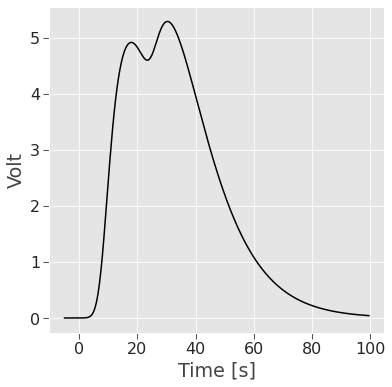

In [7]:
# Noise-free data
d = G @ mtrue

# Display predicted data using noise-free model
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, d, 'k')
ax.set(xlabel='Time [s]', ylabel='Volt');

## Adding noise to the data

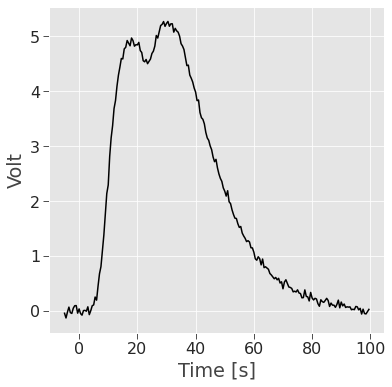

In [8]:
# The noise standard deviation
noise = 0.05

# Add random normal noise to the data
dn = d + noise*np.random.randn(M-1)

# Display predicted data plus random independent noise
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, dn, 'k')
ax.set(xlabel='Time [s]', ylabel='Volt');

## Generalized inverse solutions

Using SVD with all 210 singular values.

In [9]:
# Find Up, Sp, Vp
nkeep = N - 1
Up = U[:, :nkeep]
Vp = V[:, :nkeep]
Sp = np.diag(S[:nkeep])

# Generalized inverse solution for noise-free data (mperf) and noisy data (mn)
Gdagger = Vp @ nla.inv(Sp) @ Up.T
mperf = Gdagger @ d
mn = Gdagger @ dn

### Display generalized inverse solution for **noise-free** data

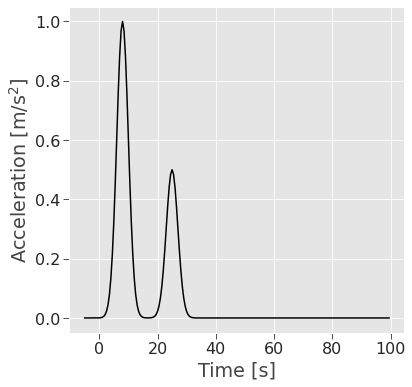

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, mperf, 'k')
ax.set(xlabel='Time [s]', ylabel=r'Acceleration [m/s$^2$]');

### Display generalized inverse solution for **noisy** data

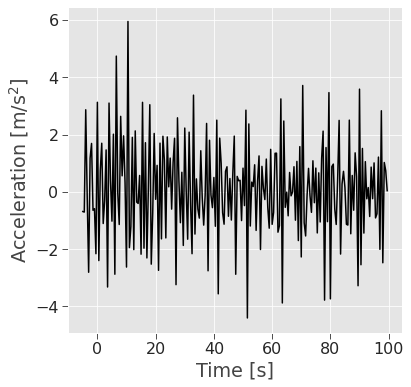

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, mn, 'k')
ax.set(xlabel='Time [s]', ylabel=r'Acceleration [m/s$^2$]');

## Truncated SVD (TSVD) solutions

Truncate SVD to 26 singular values.

In [12]:
nkeep = 26
Up = U[:, :nkeep]
Vp = V[:, :nkeep]
Sp = np.diag(S[:nkeep])

# Get model for truncated SVD (m2) with noisy data
Gdagger = Vp @ nla.inv(Sp) @ Up.T
m2 = Gdagger @ dn

### Display TSVD solution for **noisy** data

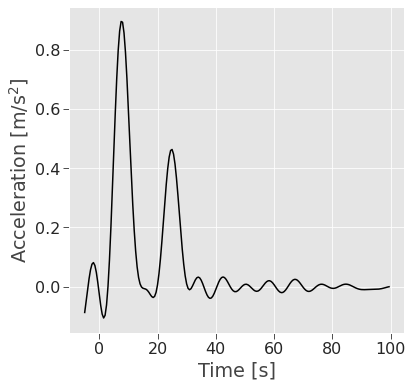

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, m2, 'k')
ax.set(xlabel='Time [s]', ylabel=r'Acceleration [m/s$^2$]');

## Model resolution matrix, $\textbf{R}_m$

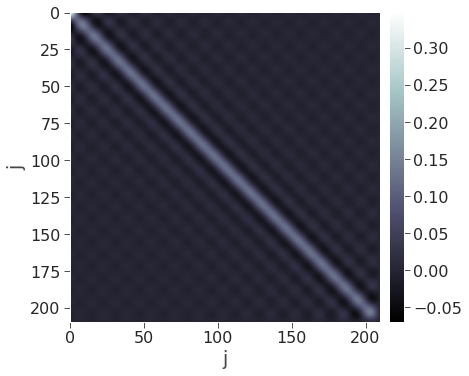

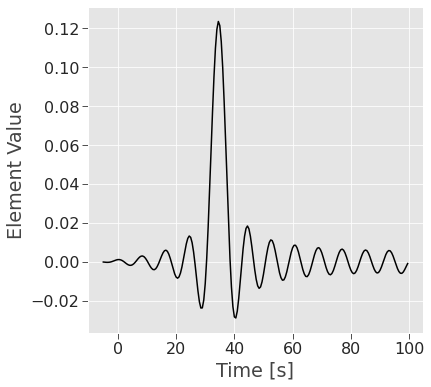

In [14]:
# get model resolution matrix for p=26
Rm = Vp @ Vp.T

# Display image of resolution matrix for TSVD solution
fig = plt.figure()
ax = fig.add_subplot(111)
cimg = ax.imshow(Rm, vmin=Rm.min(), vmax=Rm.max(), cmap='bone')
cax = get_cbar_axes(ax)
cbar = plt.colorbar(cimg, cax=cax)
ax.set(xlabel='j', ylabel='j')
ax.grid(False)

# Display a column from the model resolution matrix for TSVD solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, Rm[:, 79], 'k')
ax.set(xlabel='Time [s]', ylabel='Element Value');

## Animating TSVD solutions as `p` increases

Show successive TSVD solutions.

In [15]:
%%capture


class UpdateModel(object):
    def __init__(self, ax):
        self.ax = ax
        self.t = tt
        self.m = np.zeros(N-1, dtype=np.float64)
        self.res = np.zeros_like(self.m)
        self.mnorm = np.zeros_like(self.m)
        self.title = ''
        self.line, = ax.plot([], [], 'k-')

        # Set up plot parameters
        self.ax.set(
            xlabel='Time [s]', ylabel=r'Acceleration [m/s$^2$]',
            xlim=(tmin, tmax), ylim=(-5, 5))

        # Plot the true model
        self.ax.plot(self.t, mtrue, 'r--')

    def init(self):
        self.ax.set_title('p = 0')
        self.line.set_data([], [])
        return self.line

    def __call__(self, i):

        if i == 0:
            return self.init()

        # Adjust the predicted model to have p singular values (eq. (3.80))
        dummy = np.dot(U[:, i].T, dn) / S[i]
        self.m += np.dot(dummy, V[:, i])

        # Keep track of the residuals for each p
        self.res[i] = nla.norm((G @ self.m) - dn)

        # Keep track of the model norm for each p
        self.mnorm[i] = nla.norm(self.m)

        # Plot the newly fit model
        self.line.set_data(self.t, self.m)

        self.ax.set_title('p = {:3d}'.format(i+1))

        return self.line


# ----------

p = nla.matrix_rank(G)

fig, ax = plt.subplots(1, 1)
um = UpdateModel(ax)
anim = FuncAnimation(
    fig, um, frames=range(p), init_func=um.init, interval=50,
    blit=False, repeat=False)

### Render the animation

In [16]:
from IPython.display import HTML

HTML(anim.to_html5_video())

## Trade-off curve

Examine the trade-off curve (collected in the loop above).

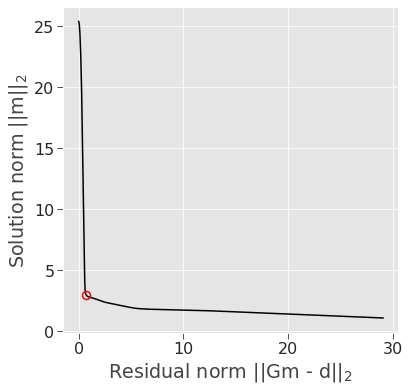

In [17]:
m = np.zeros(N - 1, dtype=np.float64)
res = np.zeros_like(m)
mnorm = np.zeros_like(m)

for i in range(p):
    # Adjust the predicted model to have p singular values (eq. (3.80))
    dummy = np.dot(U[:, i].T, dn) / S[i]
    m += np.dot(dummy, V[:, i])

    # Keep track of the residuals for each p
    res[i] = nla.norm((G @ m) - dn)

    # Keep track of the model norm for each p
    mnorm[i] = nla.norm(m)


fig, ax = plt.subplots()
ax.plot(res, mnorm, 'k')
ax.plot(res[25], mnorm[25], 'ro', mfc='None')
ax.set(
    xlabel=r'Residual norm $\Vert$Gm - d$\Vert_{2}$',
    ylabel=r'Solution norm $\Vert$m$\Vert_{2}$');